In [8]:
import os
import random as rnd
import sys

import h5py
import numpy as np

# import matplotlib.cm as mplcm
# import matplotlib.colors as mcolors
import torch
%matplotlib inline
from matplotlib import pyplot as plt
from skimage import color
from torch.utils.data import Dataset, DataLoader

sys.path.append('../')
from utils.transform_2d import RGBDTransform

In [9]:
class NYUDepthV2Dataset(Dataset):
    """
    Link to the dataset: https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
    TODO
        - merge classes
        - fix mappping id to class_name
        - add augmentation for train_set
        - add steps in transform pipeline
    """

    __data_dir = os.path.join(os.getcwd(), os.pardir, ".data")
    __set_name = "NYUDepthDatasetV2"
    __set_file = "nyu_depth_v2_labeled.mat"

    def __init__(
        self,
        data_path=None,
        split="train",
        transform=None,
        resize=False,
        verbose=True,
        random_seed=42,
        num_samples=10,
    ):
        super().__init__()
        self.data_path = os.path.abspath(
            data_path
            if data_path
            else os.path.join(self.__data_dir, self.__set_name, self.__set_file)
        )
        self.split = split
        self.transform = transform
        self.verbose = verbose
        self.random_seed = random_seed
        # rnd.seed(self.random_seed)
        self.num_samples = num_samples  # TODO remove for training on full dataset

        # Load the .mat f
        with h5py.File(self.data_path, "r") as f:
            # HxWx3XN -> NxHxWx3
            # HxWx3xN -> Nx3xHxW TODO
            self.rgb_images = torch.from_numpy(
                np.transpose(
                    f["images"][: self.num_samples].astype(np.float16) / 255.0,
                    (0, 1, 3, 2),
                )
            )
            self.depth_maps = torch.from_numpy(
                np.transpose(f["depths"][: self.num_samples], (0, 2, 1))
            )
            self.labels = torch.from_numpy(
                np.transpose(
                    f["labels"][: self.num_samples].astype(np.uint8), (0, 2, 1)
                )
            )
            chr_arr = [list(f[ref][()].flatten()) for ref in f["names"][0]]
            self.class_names = ["".join(chr(c) for c in name) for name in chr_arr]

        if self.transform:
            size = np.array(self.rgb_images.shape[2:])
            if resize:
                size = (size * resize + 0.5).astype(np.int16)
            size = tuple(size)
            std, mean = torch.std_mean(self.rgb_images.reshape(-1, 3), dim=0)  # TODO
            std_depth, mean_depth = torch.std_mean(
                self.depth_maps.reshape(-1), dim=0
            )  # TODO
            std = std.tolist()
            mean = mean.tolist()
            std.append(std_depth.item())
            mean.append(mean_depth.item())
            self.transform = RGBDTransform(resize=size, mean=mean, std=std)

    def __len__(self):
        return len(self.rgb_images)

    def __getitem__(self, idx):
        rgb_image = self.rgb_images[idx]
        depth_map = self.depth_maps[idx]
        label = self.labels[idx]

        sample = (rgb_image, depth_map, label)

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __repr__(self) -> str:
        repr = f"""
        NYUDepthV2Dataset(split={self.split}, data_path={self.data_path})
        Number of samples: {len(self)}
        Number of labels: {len(self.class_names)}
        RGB image shape: {self.rgb_images.shape}
        Depth map shape: {self.depth_maps.shape}
        RGBD sample shape: {self[-1][0].shape}
        Label shape: {self.labels.shape}"""
        return repr

    def visualize_rnd_sample(self, show_norm=False):
        rnd_idx = rnd.randint(0, len(self) - 1)
        if show_norm:
            rgbd, label = self.__getitem__(rnd_idx)
            rgb_image = rgbd[:3:, :, :]
            depth_map = rgbd[3:, :, :]
        else:
            rgb_image = self.rgb_images[rnd_idx]
            depth_map = self.depth_maps[rnd_idx]
            label = self.labels[rnd_idx]

        rgb_image = rgb_image.numpy().astype(np.float32).transpose(1, 2, 0)
        depth_map.squeeze_(0)
        # Define a discrete colormap
        # unique_labels = np.unique(label)
        # num_labels = len(unique_labels)

        # color_map = color.label2rgb(label)
        # labels = [self.label_id2name(color.rgb2label(color_map)) for color in np.unique(color_map)]
        uique_labels = np.unique(label.flatten().numpy())
        print(
            "Found the following labels:\n",
            [self.label_id2name(e) for e in uique_labels],
        )

        fig, (ax0, ax1, ax2) = plt.subplots(
            1, 3, sharex=True, sharey=True, figsize=(18, 6)
        )
        fig.suptitle(f"Sample {rnd_idx} - normalized: {show_norm}")
        ax0.imshow(rgb_image)
        ax0.set_title("RGB image")
        ax0.set_axis_off()
        ax1.imshow(depth_map.numpy(), cmap="hot", interpolation="nearest")
        ax1.set_title("Depth map")
        ax1.set_axis_off()
        # im = ax2.imshow(label, cmap=cmap, norm=norm)
        ax2.imshow(color.label2rgb(label.numpy()))
        ax2.set_title("Ground truth")
        ax2.set_axis_off()

        # colorbar = plt.colorbar(im, ax=ax2, ticks=unique_labels)
        # colorbar.set_ticklabels([f"{id}:{self.label_id2name(id)}" for id in unique_labels])

        plt.show()

    def augment_train_set(self, train_set, num_samples=1000):
        # TODO how
        augmented_train_set = train_set
        return augmented_train_set

    def split_dataset(self, split=0.8):
        """Split the dataset into two parts with the specified ratio."""
        if split > 1 or split < 0:
            raise ValueError("Split ratio must be between 0 and 1.")
        num_samples = len(self)
        num_samples_train = int(num_samples * split)
        num_samples_val = num_samples - num_samples_train
        train_set, val_set = torch.utils.data.random_split(
            self,
            [num_samples_train, num_samples_val],
            generator=torch.Generator().manual_seed(self.random_seed),
        )
        return train_set, val_set

    # def get_colors(self, num_colors):
    #     cm = plt.get_cmap("gist_rainbow")
    #     c_norm = mcolors.Normalize(vmin=0, vmax=num_colors - 1)
    #     scalar_map = mplcm.ScalarMappable(norm=c_norm, cmap=cm)
    #     colors = [scalar_map.to_rgba(i) for i in range(num_colors)]
    #     return colors

    def label_name2id(self, label_name):
        return self.class_names.index(label_name)

    def label_id2name(self, label_id):
        return self.class_names[label_id]

In [10]:
dataset = NYUDepthV2Dataset(
    data_path="/Volumes/Extreme SSD/nyu_depth_v2_labeled.mat",
    transform=RGBDTransform,
    resize=0.75,
    num_samples=10
)

In [11]:
# dataset.visualize_rnd_sample(show_norm=False)
print(dataset)


        NYUDepthV2Dataset(split=train, data_path=/Volumes/Extreme SSD/nyu_depth_v2_labeled.mat)
        Number of samples: 10
        Number of labels: 894
        RGB image shape: torch.Size([10, 3, 480, 640])
        Depth map shape: torch.Size([10, 480, 640])
        RGBD sample shape: torch.Size([4, 360, 480])
        Label shape: torch.Size([10, 480, 640])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found the following labels:
 ['book', 'cabinet', 'ceiling', 'chair', 'dishwasher', 'faucet', 'fire extinguisher', 'microwave', 'paper towel dispenser', 'pot', 'refridgerator', 'stove burner', 'table', 'bowl', 'magnet', 'sink', 'air vent']


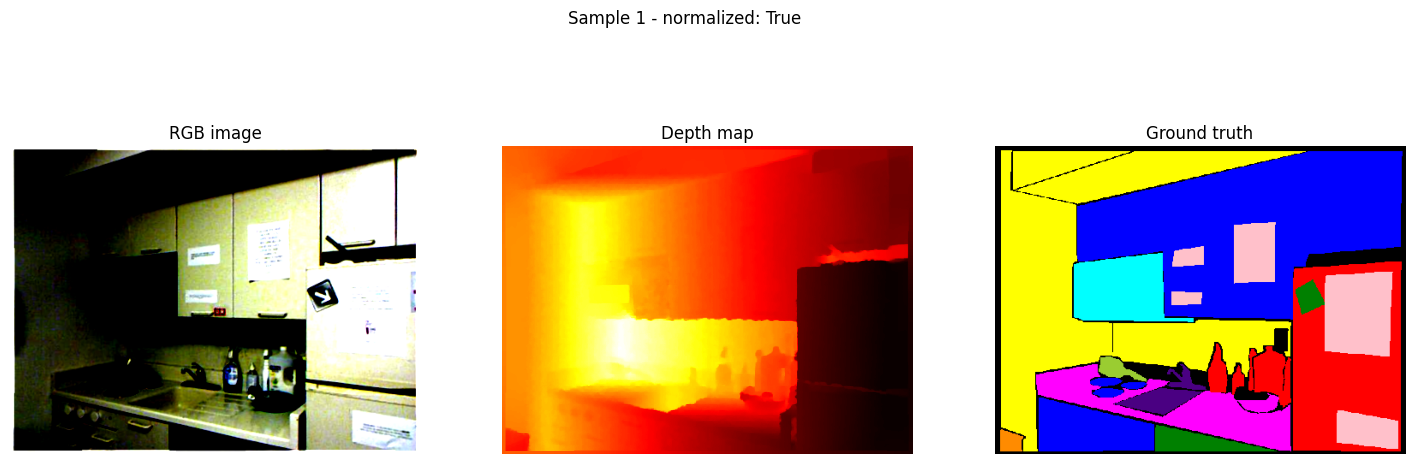

In [12]:
dataset.visualize_rnd_sample(show_norm=True)

In [17]:
train_set, test_set = dataset.split_dataset(split=0.8)
print(train_set)

# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
# print(dataloader)
# train, test = dataset.split_dataset(split=0.8)
# print(len(test), len(train))
# print(test[-2])

# train_loader, test_loader = [DataLoader(split) for split in dataset.split_dataset(split=0.8)]
# for i, data in enumerate(test_loader):
#     print(data)
#     break

In [14]:
# _, label = dataset[-1]
# label = list(set(label.flatten().tolist()))
# for i, e in enumerate(label):
#     print(f"{i}: {dataset.label_id2name(e)}")
# with open("../labels.txt", "w") as f:
#     f.write("\n".join([dataset.label_id2name(e) for e in label]))

In [15]:
# import torchvision.models.segmentation as seg_models

# seg_models.fcn_resnet50
